# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker import get_execution_role
import os 


In [4]:

# Fetch the SageMaker execution role and region
role = get_execution_role()
region = boto3.session.Session().region_name


In [ ]:

# Specify the name of the S3 Bucket
bucket_name = 'ml-data-udacity-learning'

# Create an S3 resource, not a client
s3 = boto3.resource('s3')

# Function to upload a directory to the S3 bucket
def upload_dir_to_s3(bucket_name, directory):
    bucket = s3.Bucket(bucket_name)
    for root, dirs, files in os.walk(directory):
        for file in files:
            path = os.path.join(root, file)
            key = os.path.relpath(path, directory) # remove 'dogImages' prefix
            bucket.upload_file(Filename=path, Key=key)




## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [ ]:
upload_dir_to_s3(bucket_name, 'dogImages')


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
import os 

In [6]:
session = sagemaker.Session()
bucket = session.default_bucket()


In [13]:
#TODO: Declare your HP ranges, metrics etc.

# Specify the hyperparameter ranges
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001, 0.1), # learning rate
    'batch-size': IntegerParameter(32, 256), # batch size
    "epochs": IntegerParameter(2, 5)

}

# Specify the objective metric
objective_metric_name = 'Validation Loss'
metric_definitions = [{'Name': 'Validation Loss',
                       'Regex': 'Validation Loss: ([0-9\\.]+)'}]

In [8]:
os.environ['SM_MODEL_DIR'] = 's3://'+bucket+'/model/'


In [16]:
#TODO: Create estimators for your HPs
# Create a PyTorch estimator
estimator = PyTorch(
    entry_point='hpo.py',
    role=role,
    framework_version='1.8',
    py_version='py36',
    instance_count=1,
    instance_type='ml.m4.xlarge',
)


# Set up hyperparameter tuning
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=10,
    objective_type='Minimize',
    early_stopping_type='Auto'
)

In [11]:
os.environ['SM_CHANNEL_TRAIN']= "s3://ml-data-udacity-learning/dogImages/"


In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({"training": "s3://ml-data-udacity-learning/dogImages/"}) # TODO: Remember to include your data channels


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [18]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-07-08 22:29:14 Starting - Preparing the instances for training
2023-07-08 22:29:14 Downloading - Downloading input data
2023-07-08 22:29:14 Training - Training image download completed. Training in progress.
2023-07-08 22:29:14 Uploading - Uploading generated training model
2023-07-08 22:29:14 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"Validation Loss"',
 'batch-size': '76',
 'epochs': '4',
 'lr': '0.0012063119497118988',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-07-08-21-01-32-245"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"ap-southeast-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-ap-southeast-2-429448266923/pytorch-training-2023-07-08-21-01-32-245/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [19]:
from sagemaker.debugger import Rule, rule_configs, ProfilerRule
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile


In [22]:
hp = {
    "batch-size": "76",
    "epochs": 4,
    "lr": "0.0012063119497118988",
}


In [24]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000,
    framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10",
                    "eval.save_interval": "10"}
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [41]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="dogImageClassifier",
    role=role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    py_version="py36",
    framework_version="1.8",
    hyperparameters=hp,
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config
    
)

estimator.fit({"train":  "s3://ml-data-udacity-learning/dogImages/"}, wait=True)


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dogImageClassifier-2023-07-09-01-39-27-355


Using provided s3_resource
2023-07-09 01:39:27 Starting - Starting the training job...
2023-07-09 01:39:55 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-07-09 01:40:57 Downloading - Downloading input data......
2023-07-09 01:41:57 Training - Downloading the training image......
2023-07-09 01:42:56 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-09 01:42:42,009 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-09 01:42:42,012 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-07-09 01:42:42,023 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-09 01:42:42,025 sagemaker_pytorch_

In [42]:
from smdebug.trials import create_trial
import matplotlib.pyplot as plt

[2023-07-09 03:07:38.269 datascience-1-0-ml-t3-medium-3d4e057476cc49f3a2c301be5c0b:20710 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


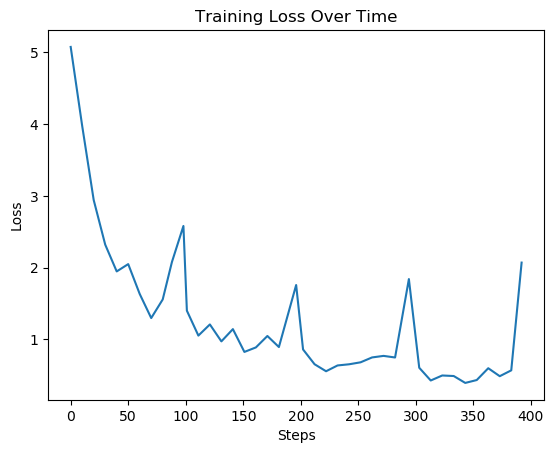

In [47]:
# TODO: Plot a debugging output.
# create a trial
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

# Get training loss values
training_loss_values = trial.tensor("CrossEntropyLoss_output_0").values()

# Prepare values for plot
# Prepare values for plot
steps = list(training_loss_values.keys())
losses = [val for val in training_loss_values.values()]


# plot the losses over time
plt.plot(steps, losses)
plt.title('Training Loss Over Time')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()



**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [48]:
# TODO: Display the profiler output
debugging_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
debugging_path


's3://sagemaker-ap-southeast-2-429448266923/dogImageClassifier-2023-07-09-01-39-27-355/rule-output'

In [54]:
! aws s3 ls {debugging_path} --recursive


2023-07-09 03:07:07     375740 dogImageClassifier-2023-07-09-01-39-27-355/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-07-09 03:07:06     223710 dogImageClassifier-2023-07-09-01-39-27-355/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-07-09 03:07:01        192 dogImageClassifier-2023-07-09-01-39-27-355/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-07-09 03:07:01        200 dogImageClassifier-2023-07-09-01-39-27-355/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-07-09 03:07:01       2057 dogImageClassifier-2023-07-09-01-39-27-355/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-07-09 03:07:01        127 dogImageClassifier-2023-07-09-01-39-27-355/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-07-09 03:07:01        199 dogImageClassifier-2023-07-09-01-39-27-355/rule-output/ProfilerReport/profiler-outp

In [55]:
! aws s3 cp {debugging_path} ./ --recursive


download: s3://sagemaker-ap-southeast-2-429448266923/dogImageClassifier-2023-07-09-01-39-27-355/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-ap-southeast-2-429448266923/dogImageClassifier-2023-07-09-01-39-27-355/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-ap-southeast-2-429448266923/dogImageClassifier-2023-07-09-01-39-27-355/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-ap-southeast-2-429448266923/dogImageClassifier-2023-07-09-01-39-27-355/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-ap-southeast-2-429448266923/dogImageClassifie

In [60]:
from IPython.display import display, HTML


In [50]:
import json

In [62]:

for obj in s3.list_objects(Bucket=bucket, Prefix=key)['Contents']:
    file = s3.get_object(Bucket=bucket, Key=obj['Key'])
    file_content = file['Body'].read().decode('utf-8')
    
    # Display HTML in the notebook
    display(HTML(file_content))


## Model Deploying

In [65]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [99]:
model_location=estimator.model_data

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

In [100]:
class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [101]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='predict.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor) 

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.g4dn.xlarge") 

INFO:sagemaker:Repacking model artifact (s3://sagemaker-ap-southeast-2-429448266923/dogImageClassifier-2023-07-09-01-39-27-355/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-ap-southeast-2-429448266923/pytorch-inference-2023-07-09-04-21-47-549/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-07-09-04-21-51-668
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-07-09-04-21-52-388
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-07-09-04-21-52-388


--------!

In [84]:
from sagemaker.serializers import IdentitySerializer
import io


In [89]:
predictor.serializer = IdentitySerializer("image/jpeg")


In [102]:
def pred_dog_breed_index(img):    
    buf = io.BytesIO()
    Image.open(img).save(buf, format="JPEG")
    response = predictor.predict(buf.getvalue(), initial_args={"ContentType": "image/jpeg"})
    
    return response


In [77]:
from IPython.display import Image as ImageDisplay



In [108]:
# TODO: Run an prediction on the endpoint

image = './dogImages/test/076.Golden_retriever/Golden_retriever_05220.jpg'


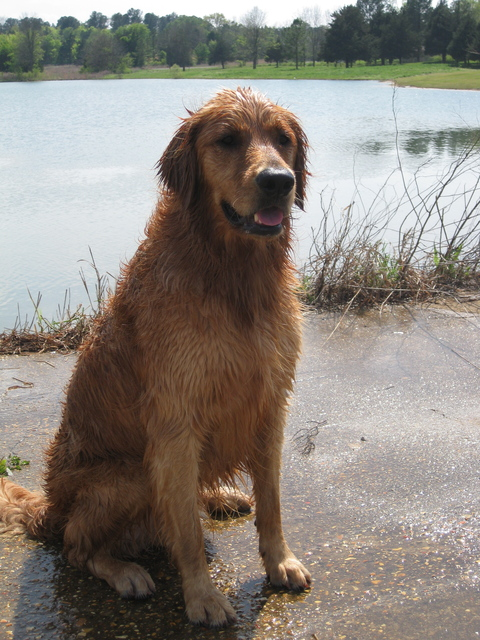

In [109]:
ImageDisplay(image)


In [104]:
pred_dog_breed_index(image)


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://ap-southeast-2.console.aws.amazon.com/cloudwatch/home?region=ap-southeast-2#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2023-07-09-04-21-52-388 in account 429448266923 for more information.

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()